In [2]:
### GSEA enrichment analysis

library(clusterProfiler)
library(tidyverse)
library(dplyr)
library(msigdbr)
library(enrichplot)
library(DOSE)
library(ggplot2)
library("ggridges")
# GSEA_r <- snakemake@output[["GSEA_r"]]
# GSEA_ridgeplot <- snakemake@output[["GSEA_ridgeplot"]]
# type <- snakemake@wildcards[["msign"]]
# signature<-snakemake@wildcards[['cluster']]
type='C8'


Registered S3 method overwritten by 'ggtree':
  method      from 
  identify.gg ggfun

clusterProfiler v4.2.2  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use clusterProfiler in published research, please cite:
T Wu, E Hu, S Xu, M Chen, P Guo, Z Dai, T Feng, L Zhou, W Tang, L Zhan, X Fu, S Liu, X Bo, and G Yu. clusterProfiler 4.0: A universal enrichment tool for interpreting omics data. The Innovation. 2021, 2(3):100141


Attaching package: ‘clusterProfiler’


The following object is masked from ‘package:stats’:

    filter


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()   masks clusterProfiler::filter(), stats::filter()
✖ dplyr::lag()      mask

[1] "sto facendo"
[1] "sto facendo"


preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (14.24% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
leading edge analysis...

done...

Picking joint bandwidth of 0.83



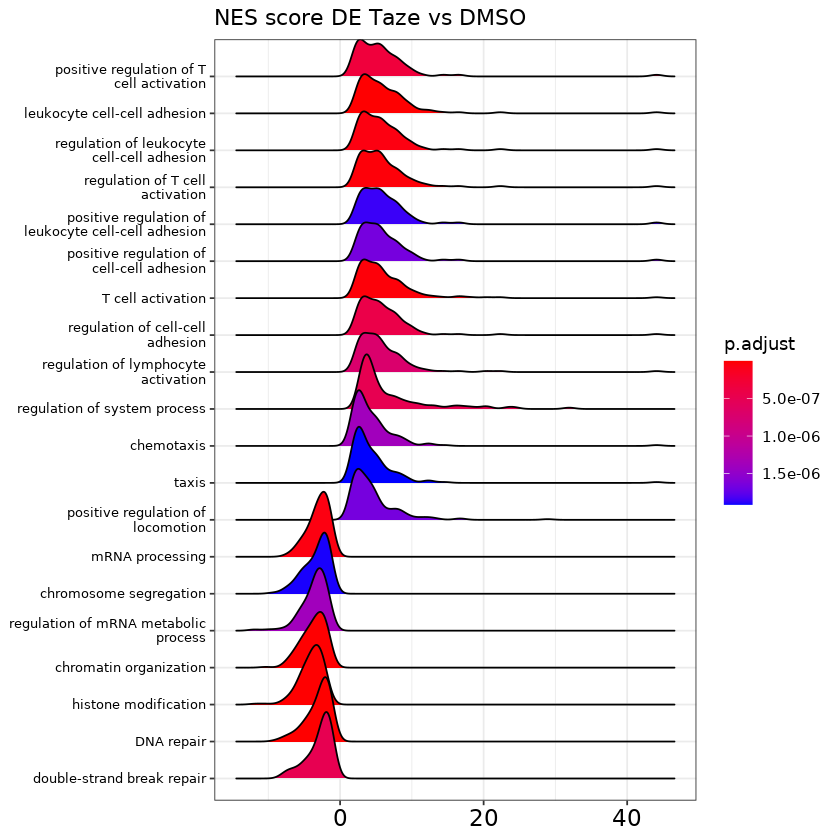

[1] "sto facendo"


png 
  2

[1] "✔️ Dotplot unificato salvato."


png 
  2

[1] "Dotplot con le stesse categorie salvato correttamente."


png 
  2

[1] "✔️ GSEA enrichment plot salvato."


'select()' returned 1:many mapping between keys and columns

'select()' returned 1:many mapping between keys and columns



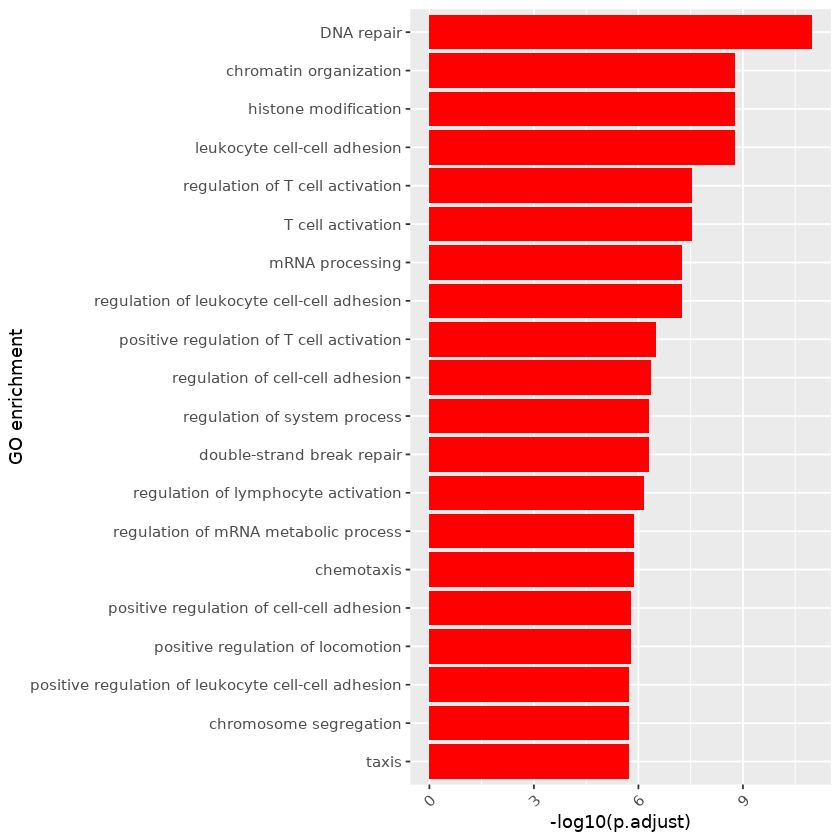

In [18]:
print("sto facendo")
waffle="/sharedFolder/Data/2_RNA_seq/TazeVSDMSO/DEfull.txt"
gene_res_df <- read.table(waffle, sep = "\t",header = TRUE,row.names=1 )
term2gene=rownames(gene_res_df)
term2gene=t(rbind(sapply(term2gene,FUN=function(x){
strsplit(x,":")[[1]]
})))
rownames(gene_res_df)=sapply(rownames(gene_res_df),FUN=function(x){
strsplit(x,":")[[1]][2]
})


# Calcola l'indice di ordinamento
sort_index <- order(-gene_res_df$stat)

# Ordina la matrice in base all'indice di ordinamento
gene_res_df <- gene_res_df[sort_index,]
geneList=cbind(rownames(gene_res_df),gene_res_df$stat)
geneList <- geneList[which(!is.na(geneList[,2])),]
geneList2=as.numeric(geneList[,2])
names(geneList2)=geneList[,1]
sort_index <- order(geneList2, decreasing = TRUE)
geneList2 <- geneList2[sort_index]
print("sto facendo")

#pdf("/sharedFolder/Data/2_RNA_seq/TazeVSDMSO/TAZENES_GO.pdf")
gse=gseGO(geneList2,ont="BP",keyType="ENSEMBL",OrgDb="org.Mm.eg.db",eps=1e-300)
ridgeplot(gse, showCategory = 20) +
  theme(axis.text.y = element_text(size = 8)) +
  labs(title = "NES score DE Taze vs DMSO")
#dev.off()
result <- gse@result
result$p.adjust=-log10(result$p.adjust)
result <- result[sort(result$p.adjust,index.return=TRUE,decreasing=TRUE)$ix, ]
result <- result[1:20, ]
result$Description <- factor(result$Description, levels = result$Description)

p <- ggplot(result, aes(x = p.adjust, y = reorder(Description, p.adjust))) +
  geom_bar(stat = "identity", fill = "red") +
  ylab("GO enrichment") +
  xlab("-log10(p.adjust)") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1))
#pdf("/sharedFolder/Data/2_RNA_seq/TazeVSDMSO/TAZEpadj_GeneOntology.pdf")
print(p)
#dev.off()
print("sto facendo")
write.csv(p$data, "/sharedFolder/Data/GO_core_enrichment_genesTAZE.csv", row.names = FALSE)
# Assicurati di avere il pacchetto DOSE caricato
require(DOSE)
# Filtra per le stesse 20 categorie come prima
selected_terms <- p$data$Description
gse_filtered <- gse
gse_filtered@result <- gse@result[gse@result$Description %in% selected_terms, ]

# Dotplot senza split
# Unificato (senza split)
dp_all <- dotplot(gse_filtered, showCategory = 20) +
  labs(title = NULL, x = "Gene Ratio", y = NULL) +
  theme_minimal() +
  theme(
    axis.text.y = element_text(size = 6),
    axis.text.x = element_text(size = 6),
    legend.text = element_text(size = 6),
    legend.title = element_text(size = 7),
    plot.margin = margin(5, 5, 5, 5)
  )

pdf("/sharedFolder/Data/2_RNA_seq/TazeVSDMSO/TAZE_dotplot_unified_narrow.pdf", width = 4, height = 5)
print(dp_all)
dev.off()


print("✔️ Dotplot unificato salvato.")


# 1. Aggiungi la colonna sign (se non già fatta)
gse@result$sign <- ifelse(gse@result$NES > 0, "activated", "suppressed")

# 2. Usa le stesse categorie del plot a barre (p$data$Description)
selected_terms <- p$data$Description

# 3. Filtra gse@result per mantenere solo quelle categorie
gse_filtered <- gse
gse_filtered@result <- gse@result[gse@result$Description %in% selected_terms, ]

# 4. Genera il dotplot solo con quei 20 GO term
dp <- dotplot(gse_filtered, showCategory = 20, split = ".sign") + 
  facet_grid(. ~ sign) + 
  labs(title = "GO terms (filtered by previous plot)")

# 5. Salva il plot
pdf("/sharedFolder/Data/2_RNA_seq/TazeVSDMSO/TAZE_dotplot_filtered.pdf", width = 10, height = 6)
print(dp)
dev.off()

print("Dotplot con le stesse categorie salvato correttamente.")
library(enrichplot)

# Scegli il GO term di interesse
# Puoi usare ID (es: "GO:0006281") oppure l'indice numerico
term_id <- "GO:0042110"  # oppure usa: which(gse@result$Description == "DNA repair")
#term_id=which(gse@result$Description == "regulation of leukocyte")

# Crea il plot
p_gsea <- gseaplot2(gse, geneSetID = term_id, title = gse@result[gse@result$ID == term_id, "Description"])

# Salva in PDF
pdf("/sharedFolder/Data/2_RNA_seq/TazeVSDMSO/GSEA_curve_leuko.pdf", width = 6, height = 5)
print(p_gsea)
dev.off()

print("✔️ GSEA enrichment plot salvato.")
library(org.Mm.eg.db)
library(dplyr)

# Funzione per creare una tabella per un singolo GO term
extract_genes_for_go <- function(go_id, description_label) {
  # 1. Estrai ENSEMBL IDs dai core_enrichment
  ensembl_ids <- unique(unlist(strsplit(
    gse@result$core_enrichment[gse@result$ID == go_id], "/"
  )))

  # 2. Subset dei dati DE
  subset_df <- gene_res_df[rownames(gene_res_df) %in% ensembl_ids, ]
  subset_df$ENSEMBL <- rownames(subset_df)

  # 3. Mappa ENSEMBL → SYMBOL
  symbols <- AnnotationDbi::select(
    org.Mm.eg.db,
    keys = subset_df$ENSEMBL,
    columns = "SYMBOL",
    keytype = "ENSEMBL"
  )

  # 4. Unisci e ordina
  final_df <- left_join(symbols, subset_df, by = "ENSEMBL") %>%
    arrange(padj)

  # 5. Salva su file
  write.csv(final_df,
            file = paste0("/sharedFolder/Data/2_RNA_seq/TazeVSDMSO/Genes_in_", description_label, ".csv"),
            row.names = FALSE)

  return(final_df)
}

# ⬇️ Esegui per entrambi i GO terms
df_dna <- extract_genes_for_go("GO:0006281", "DNArepair")
df_chromatin <- extract_genes_for_go("GO:0006325", "ChromatinOrganization")


In [20]:
format_go_table <- function(df, output_path) {
  # Crea colonna Genes
  df$Genes <- paste(df$SYMBOL, df$ENSEMBL, sep = ":")

  # Seleziona e riordina le colonne
  df_out <- df[, c("Genes", "baseMean", "log2FoldChange", "lfcSE", "stat", "pvalue", "padj")]

  # Rinomina colonne in formato leggibile
  colnames(df_out) <- c(
    "Genes", "base Mean", "log2 Fold Change", "lfcSE", "stat", "p-value", "adjusted p-value"
  )

  # Scrivi il file CSV
  write.csv(df_out, output_path, row.names = FALSE)
}

# Applica la funzione a entrambe le tabelle
format_go_table(df_dna, "/sharedFolder/Data/2_RNA_seq/TazeVSDMSO/Genes_in_DNArepair_formatted.csv")
format_go_table(df_chromatin, "/sharedFolder/Data/2_RNA_seq/TazeVSDMSO/Genes_in_ChromatinOrganization_formatted.csv")

print("✔️ File finali con nomi formattati e colonna 'Genes' unita salvati.")


[1] "✔️ File finali con nomi formattati e colonna 'Genes' unita salvati."


In [13]:
gse$Description

[1] "DNA repair"                                                                                                                                      
  [2] "chromatin organization"                                                                                                                          
  [3] "histone modification"                                                                                                                            
  [4] "leukocyte cell-cell adhesion"                                                                                                                    
  [5] "regulation of leukocyte cell-cell adhesion"                                                                                                      
  [6] "T cell activation"                                                                                                                               
  [7] "regulation of T cell activation"                                                                                                                 
  [8] "mRNA processing"                                                                                                                                 
  [9] "double-strand break repair"                                                                                                                      
 [10] "regulation of cell-cell adhesion"                                                                                                                
 [11] "regulation of lymphocyte activation"                                                                                                             
 [12] "chemotaxis"                                                                                                                                      
 [13] "chromosome segregation"                                                                                                                          
 [14] "positive regulation of T cell activation"                                                                                                        
 [15] "regulation of system process"                                                                                                                    
 [16] "positive regulation of leukocyte cell-cell adhesion"                                                                                             
 [17] "regulation of mRNA metabolic process"                                                                                                            
 [18] "taxis"                                                                                                                                           
 [19] "positive regulation of cell-cell adhesion"                                                                                                       
 [20] "leukocyte migration"                                                                                                                             
 [21] "positive regulation of cellular component movement"                                                                                              
 [22] "ATP metabolic process"                                                                                                                           
 [23] "positive regulation of cell motility"                                                                                                            
 [24] "positive regulation of locomotion"                                                                                                               
 [25] "DNA-dependent DNA replication"                                                                                                                   
 [26] "positive regulation of cell migration"                                                                                                           
 [27] "antigen processin

In [17]:
gene_res_df

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSMUSG00000027962,2298.5359,3.2197782,0.07300682,44.10243,0.000000e+00,0.000000e+00
ENSMUSG00000021596,543.6612,4.9455769,0.14820157,33.37061,3.660344e-244,2.462313e-240
ENSMUSG00000026728,679.1777,3.9701022,0.12368958,32.09730,4.807810e-226,2.156143e-222
ENSMUSG00000026418,10652.6406,1.5218479,0.04766197,31.93002,1.023245e-223,3.441685e-220
ENSMUSG00000004698,388.3792,4.5626064,0.15780910,28.91219,8.390436e-184,2.257699e-180
ENSMUSG00000032418,557.0823,3.6044642,0.12786293,28.19006,7.740804e-175,1.735746e-171
ENSMUSG00000032666,496.2972,3.6365598,0.13097068,27.76621,1.110332e-169,2.134057e-166
ENSMUSG00000046432,1372.1478,2.3311437,0.08681122,26.85302,7.776190e-159,1.307761e-155
ENSMUSG00000030352,882.6977,2.5622750,0.09855144,25.99937,5.034433e-149,7.525918e-146


[1] "sto facendo"
[1] "sto facendo"


preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (14.84% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
leading edge analysis...

done...

Picking joint bandwidth of 0.699



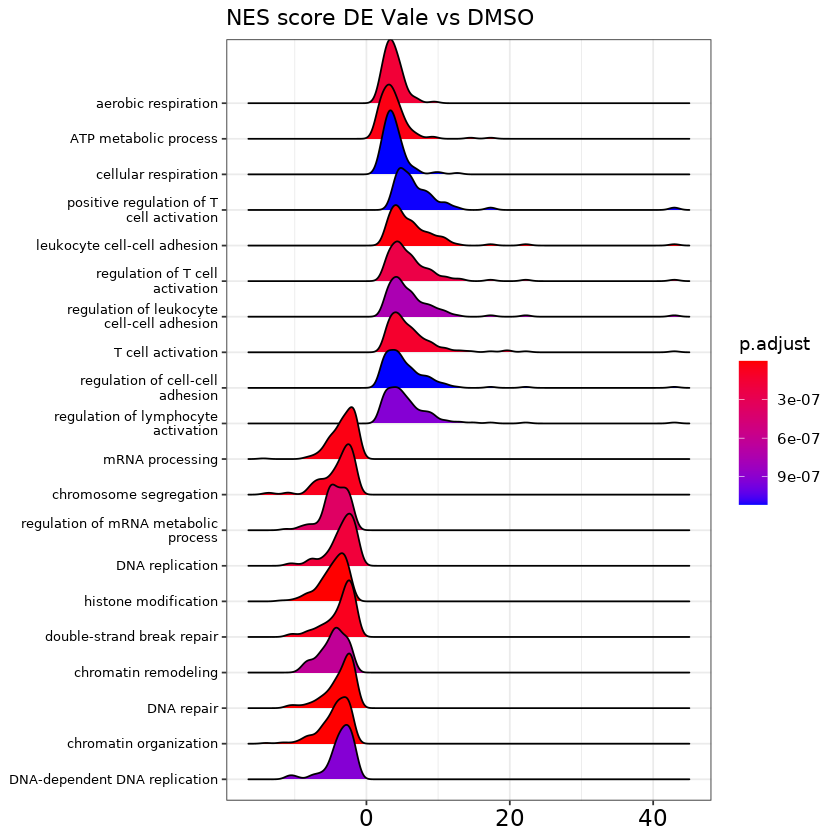

[1] "sto facendo"


'select()' returned 1:many mapping between keys and columns

'select()' returned 1:many mapping between keys and columns



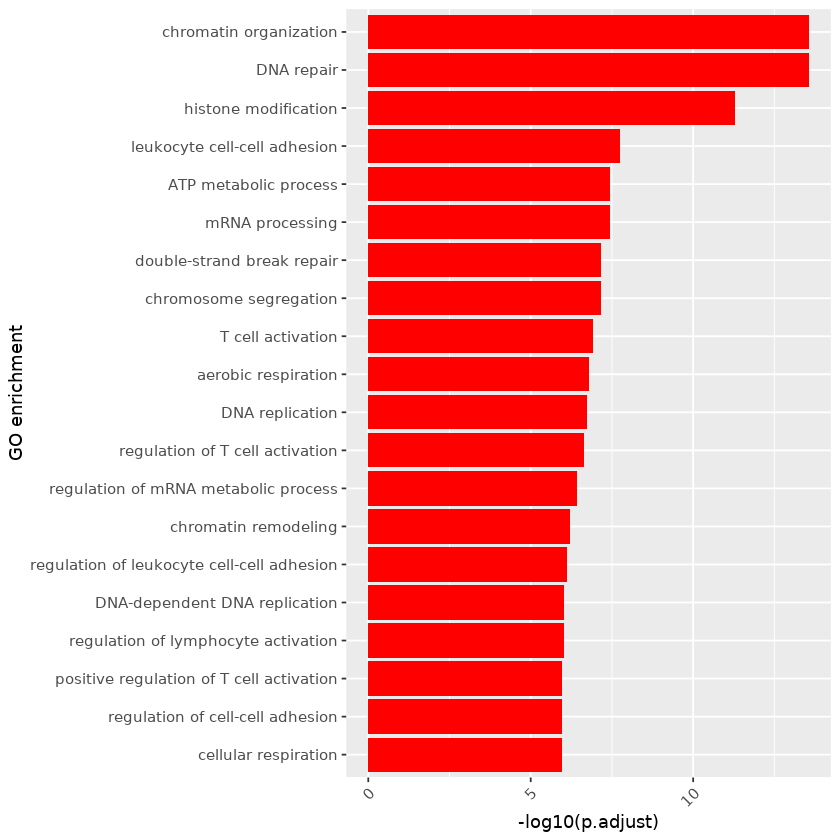

In [19]:
print("sto facendo")
waffle="/sharedFolder/Data/2_RNA_seq/ValeVSDMSO/DEfull.txt"
gene_res_df <- read.table(waffle, sep = "\t",header = TRUE,row.names=1 )
term2gene=rownames(gene_res_df)
term2gene=t(rbind(sapply(term2gene,FUN=function(x){
strsplit(x,":")[[1]]
})))
rownames(gene_res_df)=sapply(rownames(gene_res_df),FUN=function(x){
strsplit(x,":")[[1]][2]
})


# Calcola l'indice di ordinamento
sort_index <- order(-gene_res_df$stat)

# Ordina la matrice in base all'indice di ordinamento
gene_res_df <- gene_res_df[sort_index,]
geneList=cbind(rownames(gene_res_df),gene_res_df$stat)
geneList <- geneList[which(!is.na(geneList[,2])),]
geneList2=as.numeric(geneList[,2])
names(geneList2)=geneList[,1]
sort_index <- order(geneList2, decreasing = TRUE)
geneList2 <- geneList2[sort_index]
print("sto facendo")

#pdf("/sharedFolder/Data/2_RNA_seq/ValeVSDMSO/VALENES_GO.pdf")
gse=gseGO(geneList2,ont="BP",keyType="ENSEMBL",OrgDb="org.Mm.eg.db",eps=1e-300)
ridgeplot(gse, showCategory = 20) +
  theme(axis.text.y = element_text(size = 8)) +
  labs(title = "NES score DE Vale vs DMSO")
#dev.off()
result <- gse@result
result$p.adjust=-log10(result$p.adjust)
result <- result[sort(result$p.adjust,index.return=TRUE,decreasing=TRUE)$ix, ]
result <- result[1:20, ]
result$Description <- factor(result$Description, levels = result$Description)

p <- ggplot(result, aes(x = p.adjust, y = reorder(Description, p.adjust))) +
  geom_bar(stat = "identity", fill = "red") +
  ylab("GO enrichment") +
  xlab("-log10(p.adjust)") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1))
#pdf("/sharedFolder/Data/2_RNA_seq/ValeVSDMSO/Valepadj_GeneOntology.pdf")
print(p)
#dev.off()
print("sto facendo")
#write.csv(p$data, "/sharedFolder/Data/GO_core_enrichment_genesVALE.csv", row.names = FALSE)
library(org.Mm.eg.db)
library(dplyr)

# Funzione adattata per Vale vs DMSO
extract_genes_for_go_vale <- function(go_id, description_label, gene_res_df, gse) {
  ensembl_ids <- unique(unlist(strsplit(
    gse@result$core_enrichment[gse@result$ID == go_id], "/"
  )))

  subset_df <- gene_res_df[rownames(gene_res_df) %in% ensembl_ids, ]
  subset_df$ENSEMBL <- rownames(subset_df)

  symbols <- AnnotationDbi::select(
    org.Mm.eg.db,
    keys = subset_df$ENSEMBL,
    columns = "SYMBOL",
    keytype = "ENSEMBL"
  )

  final_df <- left_join(symbols, subset_df, by = "ENSEMBL") %>%
    arrange(padj)

  write.csv(final_df,
            file = paste0("/sharedFolder/Data/2_RNA_seq/ValeVSDMSO/Genes_in_", description_label, ".csv"),
            row.names = FALSE)

  return(final_df)
}

# Esegui per entrambi i GO term
df_dna_vale <- extract_genes_for_go_vale("GO:0006281", "DNArepair_VALE", gene_res_df, gse)
df_chromatin_vale <- extract_genes_for_go_vale("GO:0006325", "ChromatinOrganization_VALE", gene_res_df, gse)


In [21]:
# Funzione di formattazione per Vale (identica a prima)
format_go_table_vale <- function(df, output_path) {
  df$Genes <- paste(df$SYMBOL, df$ENSEMBL, sep = ":")

  df_out <- df[, c("Genes", "baseMean", "log2FoldChange", "lfcSE", "stat", "pvalue", "padj")]

  colnames(df_out) <- c(
    "Genes", "base Mean", "log2 Fold Change", "lfcSE", "stat", "p-value", "adjusted p-value"
  )

  write.csv(df_out, output_path, row.names = FALSE)
}

# Applica alle due tabelle di VALE
format_go_table_vale(df_dna_vale, "/sharedFolder/Data/2_RNA_seq/ValeVSDMSO/Genes_in_DNArepair_VALE_formatted.csv")
format_go_table_vale(df_chromatin_vale, "/sharedFolder/Data/2_RNA_seq/ValeVSDMSO/Genes_in_ChromatinOrganization_VALE_formatted.csv")

print("✔️ File formattati salvati anche per VALE.")


[1] "✔️ File formattati salvati anche per VALE."


In [2]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 20.04.3 LTS

Matrix products: default
BLAS:   /usr/local/lib/R/lib/libRblas.so
LAPACK: /usr/local/lib/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=C.UTF-8    LC_NUMERIC=C        LC_TIME=C          
 [4] LC_COLLATE=C        LC_MONETARY=C       LC_MESSAGES=C      
 [7] LC_PAPER=C          LC_NAME=C           LC_ADDRESS=C       
[10] LC_TELEPHONE=C      LC_MEASUREMENT=C    LC_IDENTIFICATION=C

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] ggridges_0.5.4        DOSE_3.20.1           enrichplot_1.14.2    
 [4] msigdbr_7.5.1         lubridate_1.9.2       forcats_1.0.0        
 [7] stringr_1.5.0         dplyr_1.1.2           purrr_1.0.1          
[10] readr_2.1.4           tidyr_1.3.0           tibble_3.2.1         
[13] ggplot2_3.4.2         tidyverse_2.0.0       clusterProfiler_4.2.2
[16] repr_1.1.6           

loaded via 

In [184]:
#library(R.utils)
#R.utils::setOption("clusterProfiler.download.method","auto")
#getOption("clusterProfiler.download.method")
#gse <- gseKEGG(geneList2, organism="mmu")
